In [2]:
# Comment:  Imports and Libraries

import os
import numpy as np
import pandas as pd
import seaborn as sb 
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import geopandas as gpd
from math import sqrt
from sklearn import preprocessing
from matplotlib.colors import rgb2hex
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap

%matplotlib inline
# Set seaborn style as defualt
plt.style.use('seaborn')
sb.set(style='white')
figsize = [14.70, 8.27]

# Set plot configuration
plt.rcParams['figure.dpi']= 200
plt.rcParams["figure.figsize"] = [4,2]

%matplotlib inline

In [4]:
# Comment:  Mounting Google Drive

from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [5]:
data_path = '/content/drive/My Drive/Chicago Crime/'

csv_files = ['Copy of Chicago_Crimes_2001_to_2004.csv',
             'Copy of Chicago_Crimes_2005_to_2007.csv',
             'Copy of Chicago_Crimes_2008_to_2011.csv',
             'Copy of Chicago_Crimes_2012_to_2017.csv',]
            
crimes = []

for csv_file in csv_files:
    print(f"Reading {csv_file} file:")
    csv_file_path = data_path + csv_file
    crimes.append(pd.read_csv(csv_file_path, error_bad_lines = False))
    print('\n')
    
all_crimes = pd.concat(crimes, ignore_index = True, axis = 0)

Reading Copy of Chicago_Crimes_2001_to_2004.csv file:


b'Skipping line 1513591: expected 23 fields, saw 24\n'
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (17,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)




Reading Copy of Chicago_Crimes_2005_to_2007.csv file:


b'Skipping line 533719: expected 23 fields, saw 24\n'




Reading Copy of Chicago_Crimes_2008_to_2011.csv file:


b'Skipping line 1149094: expected 23 fields, saw 41\n'




Reading Copy of Chicago_Crimes_2012_to_2017.csv file:




**Remove NaN Values**

---

In [6]:
all_crimes.dropna(inplace = True)
print("Size of Records Before Dropping NaN = %d" % len(all_crimes))
print("Size of Records After Dropping NaN = %d" % len(all_crimes))

Size of Records Before Dropping NaN = 7145213
Size of Records After Dropping NaN = 7145213


In [7]:
# lifted from https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65

def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 # Memory Usage by Migabytes
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype not in [object, bool]:  # Exclude strings
            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            '''
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True) 
            '''
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True
            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else: # Assign Int type to each Int category
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)
                    
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",props[col].dtype)
            print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    
reduce_mem_usage(all_crimes)

Memory usage of properties dataframe is : 1212.928689956665  MB
******************************
Column:  Unnamed: 0
dtype before:  int64
dtype after:  uint32
******************************
******************************
Column:  ID
dtype before:  int64
dtype after:  uint32
******************************
******************************
Column:  Beat
dtype before:  int64
dtype after:  uint16
******************************
******************************
Column:  District
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  Ward
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  Community Area
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  X Coordinate
dtype before:  float64
dtype after:  uint32
******************************
******************************
Column:  Year
dtype before:  float64
dtype after

**1. Remove Duplicates**

---

In [8]:
print("Size of initial Records = %d" % len(all_crimes))

all_crimes.drop_duplicates(subset = "ID", inplace = True)
print("Size of Records After Duplicate Removal = %d" % len(all_crimes))

Size of initial Records = 7145213
Size of Records After Duplicate Removal = 5478329


**2. Remove Undefined Locations**

---

In [9]:
all_crimes = all_crimes[((all_crimes['X Coordinate'] != 0) & (all_crimes['Y Coordinate'] != 0))]
all_crimes = all_crimes[((all_crimes['Longitude'] != 0) & (all_crimes['Latitude'] != 0))]
print("Size of Records After Dropping Undefined Locations = %d" % len(all_crimes))

Size of Records After Dropping Undefined Locations = 5478156


**3. Create Backup**

---

In [10]:
backup = all_crimes.copy()

---

## **III. Preprocessing Crime Data**

---

**1. Convert the daata format**

---

In [11]:
all_crimes.Date = pd.to_datetime(all_crimes.Date, format ='%m/%d/%Y %I:%M:%S %p')
all_crimes.index = pd.DatetimeIndex(all_crimes.Date)

**2. Select Most Common Crime Locations and Descriptions**

---

In [12]:
selectedCategories = 25
print(all_crimes['Location Description'].value_counts())

# Comment:  Find most common
mostFrequentLocations  = list(all_crimes['Location Description'].value_counts()[:selectedCategories].index)
mostFrequentDescription= list(all_crimes['Description'].value_counts()[:selectedCategories].index)

# Comment:  Replace other locations with 'OTHER'
all_crimes.loc[~all_crimes['Location Description'].isin(mostFrequentLocations) , all_crimes.columns=='Location Description'] = 'OTHER'
all_crimes.loc[~all_crimes['Description'].isin(mostFrequentLocations) , all_crimes.columns=='Description'] = 'OTHER'
print(all_crimes['Location Description'].value_counts())

STREET                 1432686
RESIDENCE               905000
APARTMENT               581886
SIDEWALK                576202
OTHER                   201138
                        ...   
BANQUET HALL                 1
LIVERY AUTO                  1
GOVERNMENT BUILDING          1
TRUCKING TERMINAL            1
LOADING DOCK                 1
Name: Location Description, Length: 170, dtype: int64
STREET                            1432686
RESIDENCE                          905000
OTHER                              605833
APARTMENT                          581886
SIDEWALK                           576202
PARKING LOT/GARAGE(NON.RESID.)     155045
ALLEY                              125094
SCHOOL, PUBLIC, BUILDING           117928
RESIDENCE-GARAGE                   108567
RESIDENCE PORCH/HALLWAY             96061
SMALL RETAIL STORE                  94339
VEHICLE NON-COMMERCIAL              91024
RESTAURANT                          81654
GROCERY FOOD STORE                  68260
DEPARTMENT STORE 

**3. Convert Column Types into Categorical**

---

In [13]:
all_crimes['Primary Type']         = pd.Categorical(all_crimes['Primary Type'])
all_crimes['Location Description'] = pd.Categorical(all_crimes['Location Description'])

**4. Remove Unnecessary Columns**

---

In [14]:
all_crimes.drop(['Unnamed: 0', 'Case Number', 'IUCR','Updated On', 'FBI Code', 'Beat', 'Ward', 'Description'], inplace = True, axis = 1)

**5. Modify Column Names**

---

In [15]:
all_crimes.columns = pd.Series(all_crimes.columns).apply(lambda x: x.replace(' ', '_').lower())
all_crimes.columns

Index(['id', 'date', 'block', 'primary_type', 'location_description', 'arrest',
       'domestic', 'district', 'community_area', 'x_coordinate',
       'y_coordinate', 'year', 'latitude', 'longitude', 'location'],
      dtype='object')

**6. Modify Categorical Variables Values**

---

In [16]:
cate_vars = ['block', 'primary_type', 'location_description']
for var in cate_vars:
  all_crimes[var] = all_crimes[var].apply(lambda x: x.title())

**7. Drop Date Index**

---

In [17]:
all_crimes.reset_index(inplace=True, drop=True)

**8. Add Month Variable**

---

In [18]:
all_crimes['month'] = all_crimes.date.dt.strftime("%b")

**9. Add Day Variable**

---

In [19]:
all_crimes['day'] = all_crimes.date.dt.day

**10. Add Weekday Variable**

---

In [20]:
all_crimes['weekday'] = all_crimes.date.dt.strftime("%a")



```
# This is formatted as code
```

**11. Splitting the Data into 4 Datasets Crimes, Locations, Dates and Coordinates**

---

In [21]:
# Crimes Dataset
crime_var_names = list(all_crimes.loc[:,'id':'domestic'])
crime_var_names = [var for var in crime_var_names if var not in ['date', 'block']]
crimes = all_crimes[crime_var_names]

# Locations Dataset
loc_var_names = ['block'] + list(all_crimes.loc[:,'district':'location'])
loc_var_names = [var for var in loc_var_names if var not in ['year', 'x_coordinate',	'y_coordinate']]
locations =  all_crimes[['id'] + loc_var_names]

# Dates Dataset
dates = all_crimes[['id', 'date', 'year', 'month', 'day', 'weekday']]

# Coordinates Dataset
coordinates = all_crimes[['id', 'x_coordinate', 'y_coordinate']]

In [22]:
all_crimes.head(2)

,id,date,block,primary_type,location_description,arrest,domestic,district,community_area,x_coordinate,y_coordinate,year,latitude,longitude,location,month,day,weekday
0,4676906,2003-03-01 00:00:00,004Xx W 42Nd Pl,Other Offense,Residence,False,True,9,61,1173974,1.87676e+06,2003,41.8172,-87.637329,"(41.817229156, -87.637328162)",Mar,1,Sat
1,4677901,2003-05-01 01:00:00,111Xx S Normal Ave,Theft,Residence,False,False,22,49,1174948,1.83105e+06,2003,41.6918,-87.635117,"(41.691784636, -87.635115968)",May,1,Thu


**12. Adding more variables into Coordinates**

---



In [45]:
coordinates['y_coordinate'] = coordinates['y_coordinate'].astype('float').astype('int')
coordinates['x_coordinate'] = coordinates['x_coordinate'].astype('int')

coordinates['id_loc'] = coordinates['x_coordinate'].astype('str') + '_' + coordinates['y_coordinate'].astype('str')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [49]:
num_locations = 100

top_danger_locs = coordinates.id_loc.value_counts()[:num_locations].reset_index()
top_danger_locs.rename(columns={'id_loc': 'count', 'index': 'id_loc'}, inplace=True)
top_danger_locs = top_danger_locs.merge(coordinates[['id_loc', 'x_coordinate', 'y_coordinate']], on='id_loc')
top_danger_locs = top_danger_locs.drop_duplicates().reset_index(drop=True)
top_danger_locs.head()

,id_loc,count,x_coordinate,y_coordinate
0,1100658_1934241,11867,1100658,1934241
1,1145727_1853720,8562,1145727,1853720
2,1176352_1900927,5851,1176352,1900927
3,1177338_1906181,3619,1177338,1906181
4,1176223_1905805,2820,1176223,1905805
...,...,...,...,...
95,1168812_1929247,1053,1168812,1929247
96,1175696_1895352,1033,1175696,1895352
97,1160001_1867170,1032,1160001,1867170
98,1180172_1881335,1026,1180172,1881335


In [28]:
%pip install geopandas

     |████████████████████████████████| 972kB 5.3MB/s 
     |████████████████████████████████| 14.8MB 314kB/s 
     |████████████████████████████████| 10.9MB 35.7MB/s 


In [54]:
fp = '/content/drive/My Drive/Chicago Crime/Shapefile/Neighborhoods_2012b.shp'
chicago = gpd.read_file(fp)

gdf = gpd.GeoDataFrame(top_danger_locs, geometry=gpd.points_from_xy(top_danger_locs['x_coordinate'], top_danger_locs['y_coordinate']))

gdf['severity'] = gdf['count'].apply(lambda x: 1 if x >= 10000
                                                          else(2 if x < 10000 and x >= 8000
                                                              else(3 if x < 8000 and x >= 6000
                                                                  else(4 if x < 6000 and x >= 4000
                                                                      else(5 if x < 4000 and x >= 2000
                                                                          else(6))))))

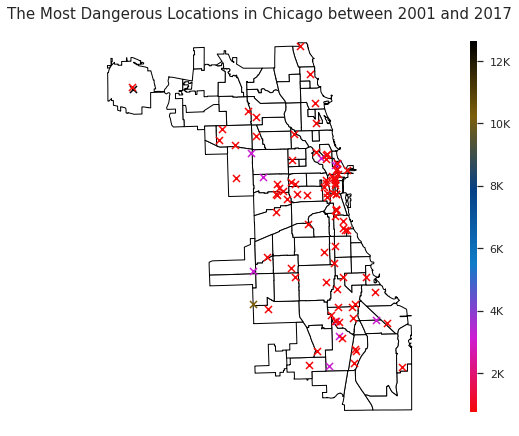

In [61]:
num_of_degrees = len(gdf.severity.unique())

color_pal = ['#F60909', '#CD1CD3', '#0F7CC8', '#064085', '#7C5F0B', '#000000'] # Custom colors
mycmap = LinearSegmentedColormap.from_list('mycmap', color_pal) # Custom Colormap

color_pal.reverse() # Reverse Colormap

ax = chicago.plot(color='white', edgecolor='black', figsize=[6, 10])

# Assign color for each degree of severity
for n, c in zip(range(1,num_of_degrees+2), color_pal):
    if n in gdf['severity'].unique():
        gdf_current = gdf.query(f'severity == {n}')
        gdf_current.plot(ax=ax, color=c, marker='x', markersize=50)
    
plt.xticks(ticks=[]), plt.yticks(ticks=[]) # Remove x and y ticks
plt.title('The Most Dangerous Locations in Chicago between 2001 and 2017', y = 1.04, fontsize=15) # Set title

sb.despine(ax=ax, left=True, bottom=True) # Remove plot borders

# Create custome colorbar
vmin, vmax = -0.5, 4.25
fig = ax.get_figure()
cax = fig.add_axes([1.0, 0.245, 0.015, 0.515])
sm = plt.cm.ScalarMappable(cmap=mycmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
# fake up the array of the scalar mappable. Urgh...
sm._A = [0, 1, 2, 3, 4]
cbar = fig.colorbar(sm, cax=cax)

cbar.set_ticks(np.arange(0, 5, 0.8))
cbar.set_ticklabels(['2K', '4K', '6K', '8K', '10K', '12K'])

cbar.outline.set_visible(False) # Remove colorbar border color

**13. Checking each DataFrame**

In [62]:
crimes.head(2)

,id,primary_type,location_description,arrest,domestic
0,4676906,Other Offense,Residence,False,True
1,4677901,Theft,Residence,False,False


In [63]:
locations.head(2)

,id,block,district,community_area,latitude,longitude,location,geometry,x_and_y
0,4676906,004Xx W 42Nd Pl,9,61,41.8172,-87.637329,"(41.817229156, -87.637328162)",POINT (1173974.000 1876757.000),1173974_1876757
1,4677901,111Xx S Normal Ave,22,49,41.6918,-87.635117,"(41.691784636, -87.635115968)",POINT (1174948.000 1831051.000),1174948_1831051


In [64]:
dates.head(2)

,id,date,year,month,day,weekday
0,4676906,2003-03-01 00:00:00,2003,Mar,1,Sat
1,4677901,2003-05-01 01:00:00,2003,May,1,Thu


In [65]:
coordinates.head(2)

,id,x_coordinate,y_coordinate,id_loc
0,4676906,1173974,1876757,1173974_1876757
1,4677901,1174948,1831051,1174948_1831051


In [66]:
top_danger_locs.head(2)

,id_loc,count,x_coordinate,y_coordinate,geometry,severity
0,1100658_1934241,11867,1100658,1934241,POINT (1100658.000 1934241.000),1
1,1145727_1853720,8562,1145727,1853720,POINT (1145727.000 1853720.000),2


**14. Saving to Google Drive**

In [73]:
crimes.to_csv('/content/drive/My Drive/Chicago Crime/crimes.csv', index=False)
locations.to_csv('/content/drive/My Drive/Chicago Crime/locations.csv', index=False)
dates.to_csv('/content/drive/My Drive/Chicago Crime/dates.csv', index=False)
coordinates.to_csv('/content/drive/My Drive/Chicago Crime/coordinates.csv', index=False)
gdf.to_csv('/content/drive/My Drive/Chicago Crime/top_danger_locs.csv', index=False)